In [1]:
import pyBigWig
import pandas as pd
import numpy as np
from multiprocessing import Process, Value, Array, Pool
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import repeat
import os
import glob
import pickle
from collections import OrderedDict

%load_ext lab_black

In [2]:
def save_object(obj, filename):
    with open(filename, "wb") as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


# sample usage
# save_object(company1, 'company1.pkl')

In [3]:
bw_path_dict = OrderedDict(
    {
        x.split("/")[-1].split(".")[0]: x
        for x in glob.glob(
            "per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*.bw"
        )
    }
)
bw_path_dict

OrderedDict([('mtscatac_Dendritic_cell',
              'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_Dendritic_cell.bw'),
             ('10xmultiome_B_cell',
              'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_B_cell.bw'),
             ('s3atac_Natural_killer_cell',
              'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_Natural_killer_cell.bw'),
             ('10xv2_Dendritic_cell',
              'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_Dendritic_cell.bw'),
             ('mtscatac_B_cell',
              'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_B_cell.bw'),
             ('10xv2_

In [4]:
bed_path_dict = {
    x.split("/")[-1].split("__")[1].replace("+", ""): x
    for x in glob.glob(
        "downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/*TOP2k.bed"
    )
}
bed_path_dict

{'Natural_killer_cell': 'downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__Natural_killer_cell__DARs.TOP2k.bed',
 'CD16_monocyte': 'downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__CD16+_monocyte__DARs.TOP2k.bed',
 'Dendritic_cell': 'downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__Dendritic_cell__DARs.TOP2k.bed',
 'B_cell': 'downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__B_cell__DARs.TOP2k.bed',
 'CD4_T_cell': 'downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__CD4+_T_cell__DARs.TOP2k.bed',
 'CD14_monocyte': 'downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__CD14+_monocyte__DARs.TOP2k.bed',
 'Cytotoxic_T_cell': 'downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__Cytotoxic_T_cell__DARs.TOP2k.be

In [5]:
tech_alias_dict = {
    "10xmultiome": "10x Multiome",
    "10xv1": "10x v1",
    "10xv11": "10x v1.1",
    "10xv2": "10x v2",
    "ddseq": "ddSEQ SureCell",
    "hydrop": "HyDrop",
    "mtscatac": "mtscATAC-seq",
    "s3atac": "s3-ATAC",
}

tech_color_palette = {
    "10xv2": "#1b9e77",
    "10xv1": "#d95f02",
    "10xv11": "#7570b3",
    "10xmultiome": "#e7298a",
    "mtscatac": "#66a61e",
    "ddseq": "#e6ab02",
    "s3atac": "#a6761d",
    "hydrop": "#666666",
}

tech_order = [
    "10xv1",
    "10xv11",
    "10xv2",
    "10xmultiome",
    "mtscatac",
    "ddseq",
    "s3atac",
    "hydrop",
]

cell_type_alias_dict = {
    "B_cell": "B cells",
    "CD14+_monocyte": "CD14+ monocytes",
    "CD4+_T_cell": "CD4+ T cells",
    "Cytotoxic_T_cell": "CD8+ T cells",
    "Dendritic_cell": "Dendritic cells",
    "Natural_killer_cell": "NK cells",
    "CD16+_monocyte": "CD16+ monocytes",
}

cell_type_order = [
    "B_cell",
    "CD14+_monocyte",
    "CD4+_T_cell",
    "Cytotoxic_T_cell",
    "Dendritic_cell",
    "Natural_killer_cell",
    "CD16+_monocyte",
]

cell_type_color_dict = {
    "B_cell": "#88CCEE",
    "CD14+_monocyte": "#CC6677",
    "CD4+_T_cell": "#DDCC77",
    "Cytotoxic_T_cell": "#117733",
    "Dendritic_cell": "#332288",
    "Natural_killer_cell": "#AA4499",
    "CD16+_monocyte": "#44AA99",
}

# generate count matrices of bigwigs in beds

In [6]:
def read_bw_values(bed_part, bw):
    bw = pyBigWig.open(bw)
    colnames = np.append(
        np.arange(-1250, 0), np.arange(0, 1250)
    )  # colnames are a range over the interval that we look at
    df = pd.DataFrame(columns=colnames)
    for line in bed_part.iterrows():
        vals = bw.values(
            line[1][0],
            int(line[1][1]) - interval_downstream,
            int(line[1][2]) + interval_upstream,
        )
        df.loc[line[0]] = vals

    return df

In [7]:
max_dict = {}
interval_downstream = 1000
interval_upstream = 1000
binsize = 20
top_n = 2000
cores = 24

In [8]:
bw_path_dict

OrderedDict([('mtscatac_Dendritic_cell',
              'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_Dendritic_cell.bw'),
             ('10xmultiome_B_cell',
              'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_B_cell.bw'),
             ('s3atac_Natural_killer_cell',
              'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_Natural_killer_cell.bw'),
             ('10xv2_Dendritic_cell',
              'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_Dendritic_cell.bw'),
             ('mtscatac_B_cell',
              'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_B_cell.bw'),
             ('10xv2_

In [9]:
count_mats_bool = False
if count_mats_bool == True:
    for sample in list(bed_path_dict.keys()):
        print(sample)
        print(bed_path_dict[sample])
        df_bed = pd.read_csv(bed_path_dict[sample], sep="\t", index_col=None)
        df_bed.columns = ["chr", "start", "stop", "name", "logFC", "strand", "pval"]
        # df_bed.set_index('name', inplace=True)
        # df_bed.index.name = None
        df_bed = df_bed[0:top_n]

        mat_dict = {}

        for key in bw_path_dict.keys():

            torun = np.array_split(df_bed, cores, axis=0)
            bw = bw_path_dict[key]
            print(f"\t{bw}")

            iterable = zip(
                torun, repeat(bw)
            )  # this is the KEY difference between this and previous module. we now iterate over all keys to do all bigwigs instead of keeping all bigwigs the same

            # Calculate
            pool = Pool(processes=cores)
            results = pool.starmap(read_bw_values, iterable)
            pool.close()
            pool.join()
            df = pd.concat(results)
            df_binned = df.groupby(np.arange(len(df.columns)) // binsize, axis=1).mean()
            df_binned_nonan = df_binned.fillna(0)
            order = df_binned_nonan.mean(axis=1).sort_values(
                ascending=False
            )  # now reorder based in maximum mean
            df_binned_nonan_ordered = df_binned_nonan.reindex(order.index)

            mat_dict[key] = df_binned_nonan_ordered

        save_object(
            mat_dict,
            "per_tech_bigwigs/"
            + sample
            + "_DARs_binsize"
            + str(binsize)
            + "_coveragemats_refined_logfcorder.pkl",
        )

        df_merged = pd.DataFrame(columns=range(0, len(mat_dict[key].columns)))
        for key in mat_dict.keys():
            df_merged = df_merged.append(mat_dict[key], ignore_index=False)

        quantiles = df_merged.quantile(
            q=0.99
        )  # for every base, calculate the quantile q value over all regions.
        maximum = (
            quantiles.max()
        )  # then, take the maxmum value out of these 250 values.
        print(
            maximum
        )  # the resulting maximum should give a cutoff that represents the 99th quantil of all values

        # alternatively, you can take a global quantile for the entire matrix (instead of per base)
        maximum = np.quantile(df_merged, 0.99)
        print(maximum)

        max_dict[sample] = maximum

        # f,ax = plt.subplots(1,len(sampleorder))
        # f.set_figheight(5)
        # f.set_figwidth(len(sampleorder)*3)

        # for key in sampleorder:
        #     g = sns.heatmap(mat_dict[key], cmap="viridis", cbar=False, ax=ax[sampleorder.index(key)], vmax=maximum, xticklabels=False, yticklabels=False)

        # save_object(f, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(top_n)+'_f.pkl')
        # save_object(ax, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(top_n)+'_ax.pkl')

    save_object(
        max_dict,
        "per_tech_bigwigs/DARs_binsize"
        + str(binsize)
        + "_max_dict_refined_logfcorder.pkl",
    )

In [10]:
cell_type_alias_dict = {
    "B_cell": "B cells",
    "CD14_monocyte": "CD14+ monocytes",
    "CD4_T_cell": "CD4+ T cells",
    "Cytotoxic_T_cell": "CD8+ T cells",
    "Dendritic_cell": "Dendritic cells",
    "Natural_killer_cell": "NK cells",
    "CD16_monocyte": "CD16+ monocytes",
}

cell_type_order = [
    "B_cell",
    "CD14_monocyte",
    "CD4_T_cell",
    "Cytotoxic_T_cell",
    "Dendritic_cell",
    "Natural_killer_cell",
    "CD16_monocyte",
]

cell_type_color_dict = {
    "B_cell": "#88CCEE",
    "CD14_monocyte": "#CC6677",
    "CD4_T_cell": "#DDCC77",
    "Cytotoxic_T_cell": "#117733",
    "Dendritic_cell": "#332288",
    "Natural_killer_cell": "#AA4499",
    "CD16_monocyte": "#44AA99",
}

In [11]:
max_dict = {}
interval_downstream = 1000
interval_upstream = 1000
binsize = 20
top_n = 2000
cores = 24

In [12]:
cell_types = list(
    set(
        [
            "_".join(x.split("/")[-1].split("_")[1:]).split(".")[0]
            for x in glob.glob(
                "per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*"
            )
        ]
    )
)

bw_path_dict_dict = {}
for cell_type in cell_types:
    # print(cell_type)
    bw_path_dict_dict[cell_type] = {
        x.split("/")[-1].split("_")[0]: x
        for x in glob.glob(
            f"per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*{cell_type}*"
        )
    }
bw_path_dict_dict

{'CD14_monocyte': {'10xv2': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_CD14_monocyte.bw',
  'hydrop': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/hydrop_CD14_monocyte.bw',
  '10xmultiome': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_CD14_monocyte.bw',
  'ddseq': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_CD14_monocyte.bw',
  'mtscatac': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_CD14_monocyte.bw',
  's3atac': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_CD14_monocyte.bw',
  '10xv11': 'per_tech_harmony_cell_type_bigwigs_n

In [13]:
def read_bw_values(bed_part, bw):
    bw = pyBigWig.open(bw)
    colnames = np.append(
        np.arange(-1250, 0), np.arange(0, 1250)
    )  # colnames are a range over the interval that we look at
    df = pd.DataFrame(columns=colnames)

    for line in bed_part.iterrows():
        try:
            vals = bw.values(
                line[1][0],
                int(line[1][1]) - interval_downstream,
                int(line[1][2]) + interval_upstream,
            )
            df.loc[line[0]] = vals
        except:
            # vals = None
            vals = list(np.zeros(2500))

    return df

In [14]:
count_mats_bool = True
if count_mats_bool == True:
    for sample in list(bed_path_dict.keys()):
        print(sample)
        print(bed_path_dict[sample])
        df_bed = pd.read_csv(bed_path_dict[sample], sep="\t", index_col=None)
        df_bed.columns = ["chr", "start", "stop", "name", "logFC", "strand", "pval"]
        # df_bed.set_index('name', inplace=True)
        # df_bed.index.name = None
        df_bed = df_bed[0:top_n]

        mat_dict = {}

        for key in bw_path_dict_dict[sample].keys():

            torun = np.array_split(df_bed, cores, axis=0)
            bw = bw_path_dict_dict[sample][key]
            print(f"\t{bw}")

            iterable = zip(
                torun, repeat(bw)
            )  # this is the KEY difference between this and previous module. we now iterate over all keys to do all bigwigs instead of keeping all bigwigs the same

            # Calculate
            pool = Pool(processes=cores)
            results = pool.starmap(read_bw_values, iterable)
            pool.close()
            pool.join()
            df = pd.concat(results)
            df_binned = df.groupby(np.arange(len(df.columns)) // binsize, axis=1).mean()
            df_binned_nonan = df_binned.fillna(0)
            order = df_binned_nonan.mean(axis=1).sort_values(
                ascending=False
            )  # now reorder based in maximum mean
            df_binned_nonan_ordered = df_binned_nonan.reindex(order.index)

            mat_dict[key] = df_binned_nonan_ordered

        save_object(
            mat_dict,
            "per_tech_harmony_cell_type_bigwigs_nonnorm/"
            + sample
            + "_DARs_binsize"
            + str(binsize)
            + "_coveragemats_refined_logfcorder.pkl",
        )

        df_merged = pd.DataFrame(columns=range(0, len(mat_dict[key].columns)))
        for key in mat_dict.keys():
            df_merged = df_merged.append(mat_dict[key], ignore_index=False)

        quantiles = df_merged.quantile(
            q=0.99
        )  # for every base, calculate the quantile q value over all regions.
        maximum = (
            quantiles.max()
        )  # then, take the maxmum value out of these 250 values.
        print(
            maximum
        )  # the resulting maximum should give a cutoff that represents the 99th quantil of all values

        # alternatively, you can take a global quantile for the entire matrix (instead of per base)
        maximum = np.quantile(df_merged, 0.99)
        print(maximum)

        max_dict[sample] = maximum

        # f,ax = plt.subplots(1,len(sampleorder))
        # f.set_figheight(5)
        # f.set_figwidth(len(sampleorder)*3)

        # for key in sampleorder:
        #     g = sns.heatmap(mat_dict[key], cmap="viridis", cbar=False, ax=ax[sampleorder.index(key)], vmax=maximum, xticklabels=False, yticklabels=False)

        # save_object(f, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(top_n)+'_f.pkl')
        # save_object(ax, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(top_n)+'_ax.pkl')

    save_object(
        max_dict,
        "per_tech_harmony_cell_type_bigwigs_nonnorm/DARs_binsize"
        + str(binsize)
        + "_max_dict_refined_logfcorder.pkl",
    )

Natural_killer_cell
downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__Natural_killer_cell__DARs.TOP2k.bed
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_Natural_killer_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv1_Natural_killer_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_Natural_killer_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv11_Natural_killer_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_Natural_killer_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_

In [15]:
top_n = 2000

binsize = 20
filenames = sorted(
    glob.glob(
        "per_tech_harmony_cell_type_bigwigs_nonnorm/*"
        + str(binsize)
        + "_coveragemats_refined_logfcorder.pkl"
    )
)
samples = [
    item.replace(
        "_DARs_binsize" + str(binsize) + "_coveragemats_refined_logfcorder.pkl", ""
    )
    for item in filenames
]
samples = [
    item.replace("per_tech_harmony_cell_type_bigwigs_nonnorm/", "") for item in samples
]
coveragemats_dict = {samples[i]: filenames[i] for i in range(len(samples))}
coveragemats_dict

{'B_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/B_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD14_monocyte': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD14_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD16_monocyte': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD16_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD4_T_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD4_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Cytotoxic_T_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Cytotoxic_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Dendritic_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Dendritic_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Natural_killer_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Natural_killer_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl'}

In [16]:
binsize = 20
filenames = sorted(
    glob.glob(
        "per_tech_harmony_cell_type_bigwigs_nonnorm/*"
        + str(binsize)
        + "_coveragemats_refined_logfcorder.pkl"
    )
)
samples = [
    item.replace(
        "_DARs_binsize" + str(binsize) + "_coveragemats_refined_logfcorder.pkl", ""
    )
    for item in filenames
]
samples = [
    item.replace("per_tech_harmony_cell_type_bigwigs_nonnorm/", "") for item in samples
]
coveragemats_dict = {samples[i]: filenames[i] for i in range(len(samples))}
coveragemats_dict

{'B_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/B_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD14_monocyte': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD14_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD16_monocyte': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD16_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD4_T_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD4_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Cytotoxic_T_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Cytotoxic_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Dendritic_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Dendritic_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Natural_killer_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Natural_killer_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl'}

In [17]:
final_sampleorder = tech_order

In [18]:
with open(
    f"per_tech_harmony_cell_type_bigwigs_nonnorm/DARs_binsize{str(binsize)}_max_dict_refined_logfcorder.pkl",
    "rb",
) as f:
    max_dict = pickle.load(f)

mat_dict = {}
max_dict = {}
df_merged = pd.DataFrame()

for key in coveragemats_dict.keys():
    df_merged_sub = pd.DataFrame()
    with open(coveragemats_dict[key], "rb") as f:
        print(f"loading {key}...")
        mat_dict = pickle.load(f)
    for subkey in final_sampleorder:
        df_merged = df_merged.append(mat_dict[subkey], ignore_index=False)
        df_merged_sub = df_merged_sub.append(mat_dict[subkey], ignore_index=False)

    max_dict[key] = np.quantile(df_merged_sub, 0.99)


maximum = np.quantile(df_merged, 0.99)
print(maximum)
print(max_dict)
max_dict

loading B_cell...
loading CD14_monocyte...
loading CD16_monocyte...
loading CD4_T_cell...
loading Cytotoxic_T_cell...
loading Dendritic_cell...
loading Natural_killer_cell...
41.6
{'B_cell': 43.9, 'CD14_monocyte': 49.5, 'CD16_monocyte': 9.5, 'CD4_T_cell': 45.90050000000046, 'Cytotoxic_T_cell': 73.4, 'Dendritic_cell': 5.95, 'Natural_killer_cell': 9.35}


{'B_cell': 43.9,
 'CD14_monocyte': 49.5,
 'CD16_monocyte': 9.5,
 'CD4_T_cell': 45.90050000000046,
 'Cytotoxic_T_cell': 73.4,
 'Dendritic_cell': 5.95,
 'Natural_killer_cell': 9.35}

In [19]:
coveragemats_dict

{'B_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/B_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD14_monocyte': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD14_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD16_monocyte': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD16_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD4_T_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD4_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Cytotoxic_T_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Cytotoxic_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Dendritic_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Dendritic_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Natural_killer_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Natural_killer_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl'}

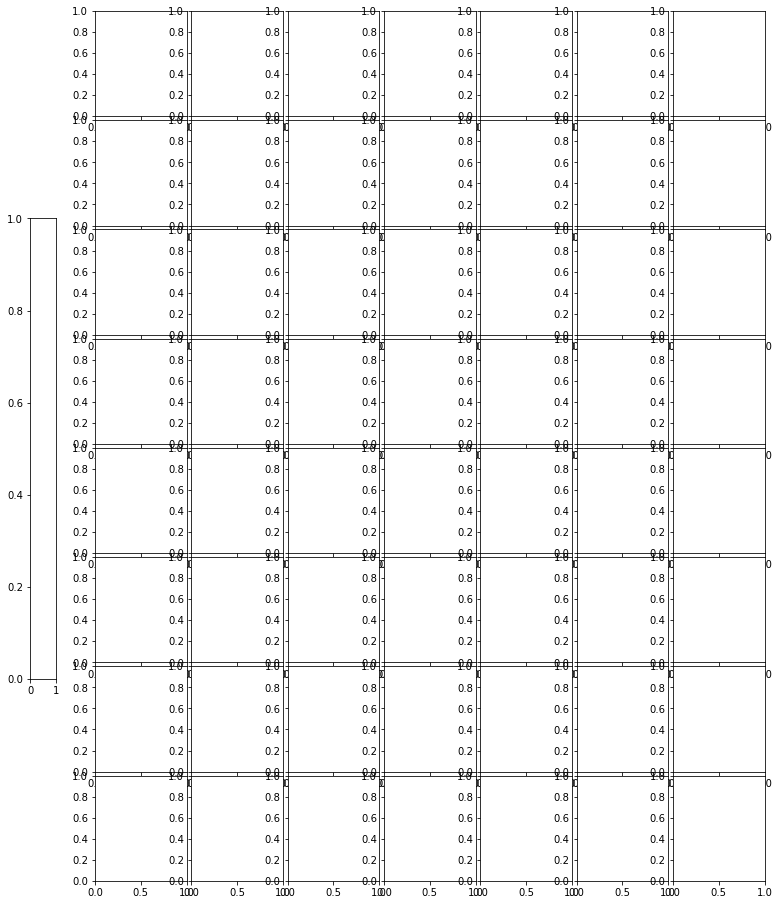

In [20]:
final_sampleorder = tech_order

height = len(final_sampleorder) * 2
width = len(final_sampleorder) * 1.5
figure, axes = plt.subplots(len(final_sampleorder), len(coveragemats_dict.keys()))

figure.set_figheight(height)
figure.set_figwidth(width)
figure.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05 / (4 / 3)
)

cbar_ax = figure.add_axes([0.05, 0.3, 0.03, 0.4])

In [21]:
cell_type_alias_dict = {
    "B_cell": "B cell",
    "CD14_monocyte": "CD14+\nmonocytes",
    "CD4_T_cell": "CD4+ T\ncells",
    "Cytotoxic_T_cell": "CD8+ T\ncells",
    "Dendritic_cell": "Dendritic\ncells",
    "Natural_killer_cell": "NK cells",
    "CD16_monocyte": "CD16+\nmonocytes",
}

cell_type_order = [
    "B_cell",
    "CD14_monocyte",
    "CD4_T_cell",
    "Cytotoxic_T_cell",
    "Dendritic_cell",
    "Natural_killer_cell",
    "CD16_monocyte",
]

cell_type_color_dict = {
    "B_cell": "#88CCEE",
    "CD14_monocyte": "#CC6677",
    "CD4_T_cell": "#DDCC77",
    "Cytotoxic_T_cell": "#117733",
    "Dendritic_cell": "#332288",
    "Natural_killer_cell": "#AA4499",
    "CD16_monocyte": "#44AA99",
}

In [22]:
with open(
    f"per_tech_harmony_cell_type_bigwigs_nonnorm/DARs_binsize{str(binsize)}_max_dict_refined_logfcorder.pkl",
    "rb",
) as f:
    max_dict = pickle.load(f)
color_max = max(max_dict.values())

In [23]:
use_max_dict = True

In [24]:
for key in coveragemats_dict.keys():
    with open(coveragemats_dict[key], "rb") as f:
        print(f"loading {key}...")
        mat_dict = pickle.load(f)

    if use_max_dict == True:
        color_max = max_dict[key]

    for subkey in final_sampleorder:
        g = sns.heatmap(
            mat_dict[subkey][0:top_n],
            cmap="viridis",
            cbar=True,
            cbar_ax=cbar_ax,
            ax=axes[
                final_sampleorder.index(subkey),
                list(coveragemats_dict.keys()).index(key),
            ],
            vmax=color_max,
            xticklabels=False,
            yticklabels=False,
        )

    print(f"{key} processed!")

loading B_cell...
B_cell processed!
loading CD14_monocyte...
CD14_monocyte processed!
loading CD16_monocyte...
CD16_monocyte processed!
loading CD4_T_cell...
CD4_T_cell processed!
loading Cytotoxic_T_cell...
Cytotoxic_T_cell processed!
loading Dendritic_cell...
Dendritic_cell processed!
loading Natural_killer_cell...
Natural_killer_cell processed!


In [25]:
for key in coveragemats_dict.keys():
    axes[0, cell_type_order.index(key)].set_title(
        f"{cell_type_alias_dict[key]}",
        fontsize=16,
        color=cell_type_color_dict[key],
    )
    print(f"{cell_type_alias_dict[key]} DARs")

B cell DARs
CD14+
monocytes DARs
CD16+
monocytes DARs
CD4+ T
cells DARs
CD8+ T
cells DARs
Dendritic
cells DARs
NK cells DARs


In [26]:
for key in final_sampleorder:
    axes[final_sampleorder.index(key), -1].set_ylabel(
        f"{tech_alias_dict[key]}",
        fontsize=16,
        color=tech_color_palette[key],
        rotation=0,
        ha="left",
    )
    axes[final_sampleorder.index(key), -1].yaxis.set_label_position("right")

In [27]:
figure.savefig(
    "plts_track/dar_carrot__per_tech_harmony_cell_type_bigwigs_nonnorm.png",
    facecolor="white",
    dpi=300,
    bbox_inches="tight",
)
figure.savefig(
    "plts_track/dar_carrot__per_tech_harmony_cell_type_bigwigs_nonnorm.tiff",
    facecolor="white",
    dpi=300,
    bbox_inches="tight",
)

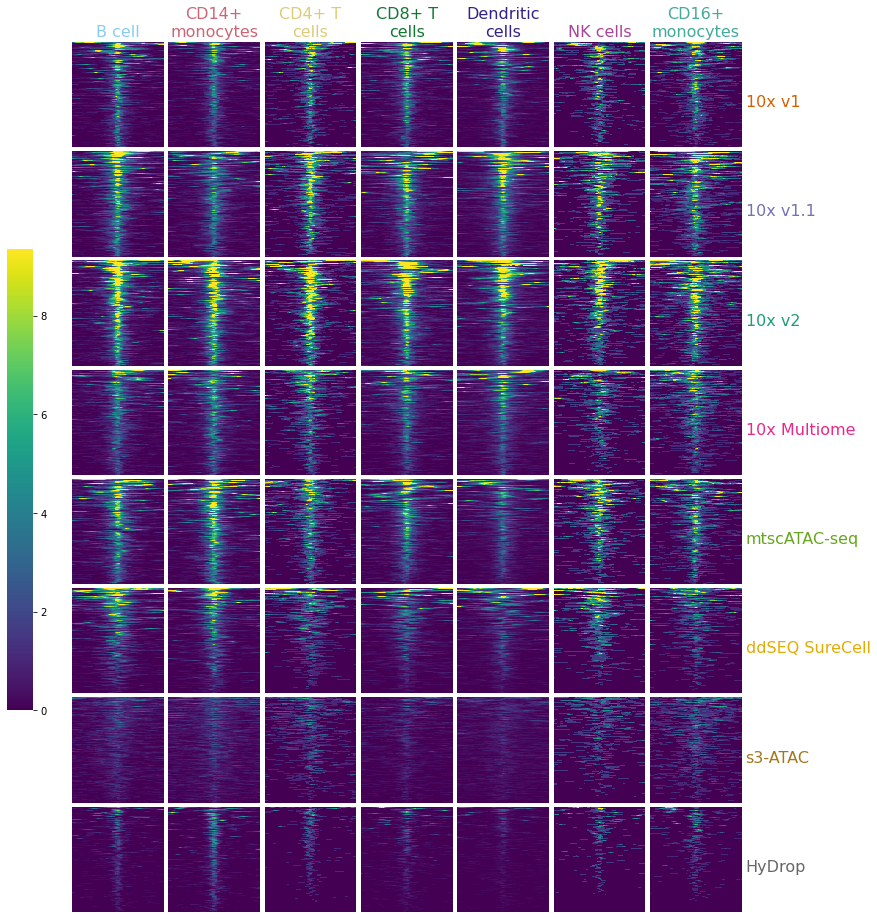

In [28]:
figure

# use this data to select a DAR that has the highest mean rank to plot

In [29]:
def read_bw_values(bed_part, bw):
    bw = pyBigWig.open(bw)
    colnames = np.append(
        np.arange(-1250, 0), np.arange(0, 1250)
    )  # colnames are a range over the interval that we look at
    df = pd.DataFrame(columns=colnames)

    for line in bed_part.iterrows():
        try:
            vals = bw.values(
                line[1][0],
                int(line[1][1]) - interval_downstream,
                int(line[1][2]) + interval_upstream,
            )
            df.loc[line[0]] = vals
        except:
            # vals = None
            vals = list(np.zeros(2500))

    return df

In [30]:
bw_path_dict_dict

{'CD14_monocyte': {'10xv2': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_CD14_monocyte.bw',
  'hydrop': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/hydrop_CD14_monocyte.bw',
  '10xmultiome': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_CD14_monocyte.bw',
  'ddseq': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_CD14_monocyte.bw',
  'mtscatac': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_CD14_monocyte.bw',
  's3atac': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_CD14_monocyte.bw',
  '10xv11': 'per_tech_harmony_cell_type_bigwigs_n

In [31]:
count_mats_bool = True
if count_mats_bool == True:
    for sample in list(bed_path_dict.keys()):
        print(sample)
        print(bed_path_dict[sample])
        df_bed = pd.read_csv(bed_path_dict[sample], sep="\t", index_col=None)
        df_bed.columns = ["chr", "start", "stop", "name", "logFC", "strand", "pval"]
        # df_bed.set_index('name', inplace=True)
        # df_bed.index.name = None
        df_bed = df_bed[0:top_n]

        mat_dict = {}

        for key in bw_path_dict_dict[sample].keys():

            torun = np.array_split(df_bed, cores, axis=0)
            bw = bw_path_dict_dict[sample][key]
            print(f"\t{bw}")

            iterable = zip(
                torun, repeat(bw)
            )  # this is the KEY difference between this and previous module. we now iterate over all keys to do all bigwigs instead of keeping all bigwigs the same

            # Calculate
            pool = Pool(processes=cores)
            results = pool.starmap(read_bw_values, iterable)
            pool.close()
            pool.join()
            df = pd.concat(results)
            df_binned = df.groupby(np.arange(len(df.columns)) // binsize, axis=1).mean()
            df_binned_nonan = df_binned.fillna(0)
            order = df_binned_nonan.mean(axis=1).sort_values(
                ascending=False
            )  # now reorder based in maximum mean
            df_binned_nonan_ordered = df_binned_nonan.reindex(order.index)

            mat_dict[key] = df_binned_nonan

        save_object(
            mat_dict,
            "per_tech_harmony_cell_type_bigwigs_nonnorm/"
            + sample
            + "_DARs_binsize"
            + str(binsize)
            + "_coveragemats_refined_darcorder.pkl",
        )

        df_merged = pd.DataFrame(columns=range(0, len(mat_dict[key].columns)))
        for key in mat_dict.keys():
            df_merged = df_merged.append(mat_dict[key], ignore_index=False)

        quantiles = df_merged.quantile(
            q=0.99
        )  # for every base, calculate the quantile q value over all regions.
        maximum = (
            quantiles.max()
        )  # then, take the maxmum value out of these 250 values.
        print(
            maximum
        )  # the resulting maximum should give a cutoff that represents the 99th quantil of all values

        # alternatively, you can take a global quantile for the entire matrix (instead of per base)
        maximum = np.quantile(df_merged, 0.99)
        print(maximum)

        max_dict[sample] = maximum

        # f,ax = plt.subplots(1,len(sampleorder))
        # f.set_figheight(5)
        # f.set_figwidth(len(sampleorder)*3)

        # for key in sampleorder:
        #     g = sns.heatmap(mat_dict[key], cmap="viridis", cbar=False, ax=ax[sampleorder.index(key)], vmax=maximum, xticklabels=False, yticklabels=False)

        # save_object(f, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(top_n)+'_f.pkl')
        # save_object(ax, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(top_n)+'_ax.pkl')

    save_object(
        max_dict,
        "per_tech_harmony_cell_type_bigwigs_nonnorm/DARs_binsize"
        + str(binsize)
        + "_max_dict_refined_darorder.pkl",
    )

Natural_killer_cell
downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__Natural_killer_cell__DARs.TOP2k.bed
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_Natural_killer_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv1_Natural_killer_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_Natural_killer_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv11_Natural_killer_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_Natural_killer_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_celltypefair_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_

In [32]:
binsize = 20
filenames = sorted(
    glob.glob(
        "per_tech_harmony_cell_type_bigwigs_nonnorm/*"
        + str(binsize)
        + "_coveragemats_refined_darorder.pkl"
    )
)
samples = [
    item.replace(
        "_DARs_binsize" + str(binsize) + "_coveragemats_refined_c\darorder.pkl", ""
    )
    for item in filenames
]
samples = [
    item.replace("per_tech_harmony_cell_type_bigwigs_nonnorm/", "") for item in samples
]
coveragemats_dict = {samples[i]: filenames[i] for i in range(len(samples))}
coveragemats_dict

{}

In [33]:
import scipy.stats as ss

In [34]:
ss.rankdata(df_binned_nonan.mean(axis=1))

array([ 102.,  106.,  150., ...,   76.,  600., 1149.])

In [35]:
ranks_df_dict = {}
for key in coveragemats_dict.keys():
    with open(coveragemats_dict[key], "rb") as f:
        print(f"loading {key}...")
        mat_dict = pickle.load(f)

    df_ranks = pd.DataFrame()
    for subkey in final_sampleorder:
        print(f"\t{subkey}")
        df_binned_nonan = mat_dict[subkey][0:top_n]
        # order = df_binned_nonan.mean(axis=1).sort_values(
        #     ascending=False
        # )  # now reorder based in maximum mean
        rank = ss.rankdata(df_binned_nonan.mean(axis=1))

        df_ranks[subkey] = rank

    ranks_df_dict[key] = df_ranks
    print(f"{key} processed!")

In [36]:
bed_path_dict

{'Natural_killer_cell': 'downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__Natural_killer_cell__DARs.TOP2k.bed',
 'CD16_monocyte': 'downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__CD16+_monocyte__DARs.TOP2k.bed',
 'Dendritic_cell': 'downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__Dendritic_cell__DARs.TOP2k.bed',
 'B_cell': 'downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__B_cell__DARs.TOP2k.bed',
 'CD4_T_cell': 'downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__CD4+_T_cell__DARs.TOP2k.bed',
 'CD14_monocyte': 'downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__CD14+_monocyte__DARs.TOP2k.bed',
 'Cytotoxic_T_cell': 'downstream_analysis/DARs/master_celltypefair_1.FIXEDCELLS/master_celltypefair_1.FIXEDCELLS__Cytotoxic_T_cell__DARs.TOP2k.be

In [37]:
df_ranks["10xv1 10xv11 10xv2 10xmultiome mtscatac".split()]

NameError: name 'df_ranks' is not defined

In [ ]:
df_ranks

In [ ]:
df_normalized

In [ ]:
best_dar_dict = {}
for cell_type, df_ranks in ranks_df_dict.items():
    cell_type = cell_type.split("_DARs")[0]

    txg_ranks = df_ranks["10xv1 10xv11 10xv2 10xmultiome mtscatac".split()].median(
        axis=1
    )
    df_normalized = df_ranks["ddseq s3atac hydrop".split()]
    df_normalized["txg"] = txg_ranks
    rank = df_normalized.median(axis=1).sort_values(ascending=True).index[0]

    df_bed = pd.read_csv(bed_path_dict[cell_type], sep="\t", index_col=None)
    df_bed.columns = ["chr", "start", "stop", "name", "logFC", "strand", "pval"]

    best_dar_dict[cell_type] = (
        df_bed.iloc[rank]["chr"]
        + ":"
        + str(df_bed.iloc[rank]["start"])
        + "-"
        + str(df_bed.iloc[rank]["stop"])
    )

In [ ]:
best_dar_dict

now plot that in dar_traces